In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer

In [3]:
df = pd.read_csv('../house_prices_selection.csv')
print(df.shape)
df.head()


(1460, 32)


,EVI,ZoningScore,MSZoning_RL,LotConfig_CulDSac,LandContour_HLS,LotShape_IR2,Condition1_Norm,Condition1_Feedr,LotShape_Reg,MSZoning_RM,...,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,GrLivArea,TotalBsmtSF,1stFlrSF,BsmtQual,CentralAir,Foundation
0,0.437530,0.835044,True,False,False,False,True,False,True,False,...,7,2003,2003,196.0,1710,856,856,Gd,Y,PConc
1,0.364741,0.835044,True,False,False,False,False,True,True,False,...,6,1976,1976,0.0,1262,1262,1262,Gd,Y,CBlock
2,0.411955,0.835044,True,False,False,False,True,False,False,False,...,7,2001,2002,162.0,1786,920,920,Gd,Y,PConc
3,0.394783,0.835044,True,False,False,False,True,False,False,False,...,7,1915,1970,0.0,1717,756,961,TA,Y,BrkTil
4,0.399533,0.835044,True,False,False,False,True,False,False,False,...,8,2000,2000,350.0,2198,1145,1145,Gd,Y,PConc


In [4]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
boolean_features = df.select_dtypes(include=['bool']).columns.tolist()

print(f"Coloane numerice ({len(numerical_features)}): {numerical_features}")
print(f"\nColoane categorice ({len(categorical_features)}): {categorical_features}")   
print(f"\nColoane booleene ({len(boolean_features)}): {boolean_features}")

Coloane numerice (19): ['EVI', 'ZoningScore', 'Price_per_m^2', 'PDI', 'SalePrice', 'LotFrontage', 'LotArea', 'WoodDeckSF', 'OpenPorchSF', 'FullBath', 'GarageCars', 'GarageArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF']

Coloane categorice (5): ['KitchenQual', 'PavedDrive', 'BsmtQual', 'CentralAir', 'Foundation']

Coloane booleene (8): ['MSZoning_RL', 'LotConfig_CulDSac', 'LandContour_HLS', 'LotShape_IR2', 'Condition1_Norm', 'Condition1_Feedr', 'LotShape_Reg', 'MSZoning_RM']


In [5]:
numerical_features.remove('SalePrice') 
print(f"Coloane numerice ({len(numerical_features)}): {numerical_features}")
print(f"\nColoane categorice ({len(categorical_features)}): {categorical_features}")

Coloane numerice (18): ['EVI', 'ZoningScore', 'Price_per_m^2', 'PDI', 'LotFrontage', 'LotArea', 'WoodDeckSF', 'OpenPorchSF', 'FullBath', 'GarageCars', 'GarageArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF']

Coloane categorice (5): ['KitchenQual', 'PavedDrive', 'BsmtQual', 'CentralAir', 'Foundation']


In [6]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(f"\nValori lipsă în dataset:")
print(missing_df)


Valori lipsă în dataset:
         Column  Missing_Count  Percentage
13  LotFrontage            259   17.739726
29     BsmtQual             37    2.534247
25   MasVnrArea              8    0.547945


In [7]:
df_test = pd.read_csv('../data/Cornescu_Darius_selected_features.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SalePrice          1460 non-null   int64  
 1   LotFrontage        1460 non-null   float64
 2   ZoningScore        1460 non-null   float64
 3   EVI                1460 non-null   float64
 4   Price_per_m^2      1460 non-null   float64
 5   LotArea            1460 non-null   int64  
 6   PDI                1460 non-null   float64
 7   MSZoning_RL        1460 non-null   bool   
 8   LotConfig_CulDSac  1460 non-null   bool   
 9   LotShape_IR2       1460 non-null   bool   
 10  LandContour_HLS    1460 non-null   bool   
 11  Condition1_Norm    1460 non-null   bool   
 12  Condition1_Feedr   1460 non-null   bool   
 13  LotShape_Reg       1460 non-null   bool   
 14  MSZoning_RM        1460 non-null   bool   
dtypes: bool(8), float64(5), int64(2)
memory usage: 91.4 KB


In [8]:
missing_values = df_test.isnull().sum()
missing_percent = (missing_values / len(df_test)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(f"\nValori lipsă în dataset:")
print(missing_df)


Valori lipsă în dataset:
Empty DataFrame
Columns: [Column, Missing_Count, Percentage]
Index: []


In [9]:
for cols in boolean_features:
    df[cols] = df[cols].astype(int)

numerical_features.extend(boolean_features)
print(f"Coloane numerice (inclusiv boolean) ({len(numerical_features)}): {numerical_features}")
print(f"\nColoane categorice ({len(categorical_features)}): {categorical_features}")

Coloane numerice (inclusiv boolean) (26): ['EVI', 'ZoningScore', 'Price_per_m^2', 'PDI', 'LotFrontage', 'LotArea', 'WoodDeckSF', 'OpenPorchSF', 'FullBath', 'GarageCars', 'GarageArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'MSZoning_RL', 'LotConfig_CulDSac', 'LandContour_HLS', 'LotShape_IR2', 'Condition1_Norm', 'Condition1_Feedr', 'LotShape_Reg', 'MSZoning_RM']

Coloane categorice (5): ['KitchenQual', 'PavedDrive', 'BsmtQual', 'CentralAir', 'Foundation']


In [10]:
X = df.drop('SalePrice', axis=1)
Y = df['SalePrice']
print(f"Features shape: {X.shape}")
print(f"Target shape: {Y.shape}")

Features shape: (1460, 31)
Target shape: (1460,)


In [11]:
df_clean = df.dropna()
X_clean = df_clean.drop('SalePrice', axis=1)
Y_clean = df_clean['SalePrice']
print(f"\nDataset după eliminarea valorilor lipsă: {df_clean.shape}")
print(f"Rânduri eliminate: {len(df) - len(df_clean)}")


Dataset după eliminarea valorilor lipsă: (1164, 32)
Rânduri eliminate: 296


In [12]:
numeric_features_clean = X_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_clean = X_clean.select_dtypes(include=['object']).columns.tolist()

In [18]:
preprocessor_dropna = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_clean),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features_clean)
    ])

pipeline_dropna = Pipeline([
    ('preprocessor', preprocessor_dropna),
    ('regressor', LinearRegression())
])

X_train_dropna, X_test_dropna, Y_train_dropna, Y_test_dropna = train_test_split( X_clean, Y_clean, test_size=0.2, random_state=42)

pipeline_dropna.fit(X_train_dropna, Y_train_dropna)
Y_pred_dropna = pipeline_dropna.predict(X_test_dropna)

mae_dropna = mean_absolute_error(Y_test_dropna, Y_pred_dropna)
rmse_dropna = np.sqrt(mean_squared_error(Y_test_dropna, Y_pred_dropna))
r2_dropna = r2_score(Y_test_dropna, Y_pred_dropna)

print(f"\nREZULTATE ABORDAREA 1 (dropna):")
print(f"MAE: ${mae_dropna:,.2f}")
print(f"RMSE: ${rmse_dropna:,.2f}")
print(f"R² Score: {r2_dropna:.4f}")




REZULTATE ABORDAREA 1 (dropna):
MAE: $21,732.42
RMSE: $35,344.64
R² Score: 0.8358


In [19]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor_imputer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline_imputer = Pipeline([
    ('preprocessor', preprocessor_imputer),
    ('regressor', LinearRegression())
])

X_train_imputer, X_test_imputer, Y_train_imputer, Y_test_imputer = train_test_split( X, Y, test_size=0.2, random_state=42 )

pipeline_imputer.fit(X_train_imputer, Y_train_imputer)
y_pred_imputer = pipeline_imputer.predict(X_test_imputer)

mae_imputer = mean_absolute_error(Y_test_imputer, y_pred_imputer)
rmse_imputer = np.sqrt(mean_squared_error(Y_test_imputer, y_pred_imputer))
r2_imputer = r2_score(Y_test_imputer, y_pred_imputer)

print(f"\nREZULTATE ABORDAREA 2 (SimpleImputer):")
print(f"MAE: ${mae_imputer:,.2f}")
print(f"RMSE: ${rmse_imputer:,.2f}")
print(f"R² Score: {r2_imputer:.4f}")


REZULTATE ABORDAREA 2 (SimpleImputer):
MAE: $21,892.38
RMSE: $34,297.28
R² Score: 0.8466


**Rezultatele celor două abordări sunt apropiate, însă diferă în moduri relevante.** Abordarea 1 (dropna) oferă un MAE puțin mai bun, dar un RMSE mai slab și un scor R² mai mic. În schimb, Abordarea 2 (cu *KNNImputer*) are un MAE ușor mai mare, însă obține cel mai mic RMSE și cel mai ridicat R², indicând o capacitate mai bună de a explica variația datelor și o performanță globală mai stabilă.

**Per ansamblu, metoda cu imputare pare mai potrivită pentru acest set de date**, deoarece păstrează mai multe informații și conduce la un model cu performanță generală superioară.


# Next laboratory :
```
Azi continuam lucrul pe notebook-ul de data trecuta. Planul este urmatorul:
Incarcam datasetul cu toate datele.
Cream pipeline-uri folosind SimpleImputer si OneHotEncoder pentru variabilele categorice.
Comparam modelele Linear Regression, DecisionTreeRegressor si RandomForestRegressor.
Pe fiecare model vom aplica Cross Validation impreuna cu GridSearchCV.
```

In [19]:
numerical_transformer_decision_tree = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7))
])

categorical_transformer_decision_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor_decision_tree = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_decision_tree, numerical_features),
        ('cat', categorical_transformer_decision_tree, categorical_features)
    ])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [20]:
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'regressor__max_depth': [5, 10, 15, 20, None],
            'regressor__min_samples_split': [2, 5, 10, 20],
            'regressor__min_samples_leaf': [1, 2, 4, 8],
            'regressor__max_features': ['sqrt', 'log2', None],
            'regressor__criterion': ['squared_error', 'friedman_mse']
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 300, 500],
            'regressor__max_depth': [10, 15, 20, None],
            'regressor__min_samples_leaf': [1, 2, 4, 8],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__max_features': ['sqrt', 'log2', None],
            'regressor__bootstrap': [True]
        }
    }
}


In [21]:
results = {}
for model_name, configurations in models.items():
    print(f"\nTunning model: {model_name}")

    pripeline = Pipeline([
        ('preprocessor', preprocessor_decision_tree),
        ('regressor', configurations['model'])
    ])

    cross_validation = cross_val_score(pripeline, X_train, Y_train, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    print(f"\nCross-Validation MAE: ${-cross_validation.mean():,.2f} (+/- ${cross_validation.std():,.2f})")

    if configurations['params']:
        grid_search = GridSearchCV(pripeline, configurations['params'], cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
        best_model = grid_search.best_estimator_
    else:
        best_model = pripeline
        best_model.fit(X_train, Y_train)
    
    Y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    r2 = r2_score(Y_test, Y_pred)

    results[model_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'model': best_model
    }
    
    print(f"\n--- REZULTATE FINALE ---")
    print(f"MAE: ${mae:,.2f}")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"R² Score: {r2:.4f}")




Tunning model: Linear Regression

Cross-Validation MAE: $20,967.46 (+/- $2,470.91)

--- REZULTATE FINALE ---
MAE: $21,892.38
RMSE: $34,297.28
R² Score: 0.8466

Tunning model: Decision Tree

Cross-Validation MAE: $26,126.09 (+/- $3,630.17)
Best parameters: {'regressor__criterion': 'squared_error', 'regressor__max_depth': 20, 'regressor__max_features': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10}

--- REZULTATE FINALE ---
MAE: $21,060.28
RMSE: $32,200.02
R² Score: 0.8648

Tunning model: Random Forest

Cross-Validation MAE: $17,447.79 (+/- $1,544.83)
Best parameters: {'regressor__bootstrap': True, 'regressor__max_depth': 15, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 500}

--- REZULTATE FINALE ---
MAE: $16,132.14
RMSE: $27,392.48
R² Score: 0.9022


| # | Model             | MAE       | RMSE      | R²     |
|---|-------------------|-----------|-----------|--------|
| 0 | Linear Regression | 21892.38  | 34297.28  | 0.8466 |
| 1 | Decision Tree     | 21060.28  | 32200.02  | 0.8648 |
| **2** | **Random Forest**     | **16132.14**  | **27392.48**  | **0.9022** |

## Comparație între modele

- **Random Forest** este modelul cu cea mai bună performanță:
  - Are **cel mai mic MAE (~16.1k)** → greșeală medie absolută cea mai mică în estimarea prețului.
  - Are **cel mai mic RMSE (~27.4k)** → penalizează mai puțin erorile mari, ceea ce arată o predicție mai stabilă.
  - Are **cel mai mare R² (~0.90)** → explică aproximativ 90% din variația prețului.

- **Decision Tree**:
  - Performanță **mai bună decât Linear Regression** (MAE și RMSE mai mici, R² mai mare).

- **Linear Regression**:
  - Este cel mai simplu și mai ușor de interpretat model, dar:
  - Are **MAE și RMSE mai mari** și **R² mai mic** față de modelele bazate pe arbori, ceea ce arată că nu surprinde suficient de bine relațiile neliniare din date.


# Laborator 19 noiembrie

In [13]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [16]:
models_boosting = {
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [500],
            'regressor__max_depth': [3],
            'regressor__learning_rate': [0.1],
            'regressor__subsample': [0.7],
            'regressor__colsample_bytree': [0.8]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [500],
            'regressor__max_depth': [5],
            'regressor__learning_rate': [0.1],
            'regressor__subsample': [0.7],
            'regressor__colsample_bytree': [0.7]
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=42, verbose=False, allow_writing_files=False),
        'params': {
            'regressor__iterations': [500],
            'regressor__depth': [5],
            'regressor__learning_rate': [0.1],
            'regressor__subsample': [0.7]
        }
    }
}

In [17]:
numerical_transformer_catboost = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7))
])

categorical_transformer_catboost = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor_catboost = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_catboost, numerical_features),
        ('cat', categorical_transformer_catboost, categorical_features)
    ]
)

In [20]:
results_boosting = {}

for model_name, configurations in models_boosting.items():
    print(f"Training model: {model_name}")
    
    if model_name == 'CatBoost':
        preprocessor_used = preprocessor_catboost

        configurations['model'].set_params( allow_writing_files=False, verbose=0)

        if categorical_features:
            cat_indices = list(range(len(numerical_features), len(numerical_features) + len(categorical_features)))
            configurations['model'].set_params(cat_features=cat_indices)
    else:
        preprocessor_used = preprocessor_decision_tree
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor_used),
        ('regressor', configurations['model'])
    ])
    
    cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    print(f"\nCross-Validation MAE: ${-cv_scores.mean():,.2f} (+/- ${cv_scores.std():,.2f})")
    
    if configurations['params']:
        print(f"\nRunning GridSearchCV with {len(configurations['params'])} parameter(s)...")
        grid_search = GridSearchCV(pipeline, configurations['params'], cv=5, n_jobs=-1,  scoring='neg_mean_absolute_error', verbose=1)
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_
        print(f"\nBest parameters: {grid_search.best_params_}")
        print(f"Best CV MAE: ${-grid_search.best_score_:,.2f}")
    else:
        best_model = pipeline
        best_model.fit(X_train, Y_train)
    
    Y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    r2 = r2_score(Y_test, Y_pred)
    
    results_boosting[model_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'CV_MAE_mean': -cv_scores.mean(),
        'CV_MAE_std': cv_scores.std(),
        'model': best_model
    }
    
    print(f"\n--- REZULTATE FINALE ---")
    print(f"MAE: ${mae:,.2f}")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"R² Score: {r2:.4f}")

Training model: XGBoost

Cross-Validation MAE: $15,617.41 (+/- $1,389.79)

Running GridSearchCV with 5 parameter(s)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 500, 'regressor__subsample': 0.7}
Best CV MAE: $11,343.96

--- REZULTATE FINALE ---
MAE: $9,601.55
RMSE: $14,828.78
R² Score: 0.9713
Training model: LightGBM

Cross-Validation MAE: $13,731.99 (+/- $1,280.87)

Running GridSearchCV with 5 parameter(s)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2769
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 38
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] N

c:\Users\dariu\Documents\GithubRepos\house-price-prediction-integra\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Cross-Validation MAE: $11,388.74 (+/- $964.87)

Running GridSearchCV with 4 parameter(s)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters: {'regressor__depth': 5, 'regressor__iterations': 500, 'regressor__learning_rate': 0.1, 'regressor__subsample': 0.7}
Best CV MAE: $11,115.09

--- REZULTATE FINALE ---
MAE: $9,999.26
RMSE: $16,232.77
R² Score: 0.9656


In [ ]:
results_df = pd.DataFrame({
    'Model': list(results_boosting.keys()),
    'MAE': [results_boosting[model]['MAE'] for model in results_boosting.keys()],
    'RMSE': [results_boosting[model]['RMSE'] for model in results_boosting.keys()],
    'R²': [results_boosting[model]['R²'] for model in results_boosting.keys()],
    'CV MAE (mean)': [results_boosting[model]['CV_MAE_mean'] for model in results_boosting.keys()],
    'CV MAE (std)': [results_boosting[model]['CV_MAE_std'] for model in results_boosting.keys()]
})

results_df = results_df.sort_values('MAE')
results_df = results_df.reset_index(drop=True)

print("\n" + "="*100)
print("COMPARAȚIE FINALĂ - TOATE MODELELE")
print("="*100)
print(results_df.to_string(index=False))


COMPARAȚIE FINALĂ - TOATE MODELELE
   Model          MAE         RMSE       R²  CV MAE (mean)  CV MAE (std)
 XGBoost  9601.552734 14828.782283 0.971332   15617.405273   1389.792161
CatBoost  9999.264278 16232.765019 0.965646   11388.735889    964.866594
LightGBM 11630.609876 20253.782460 0.946519   13731.989383   1280.866429


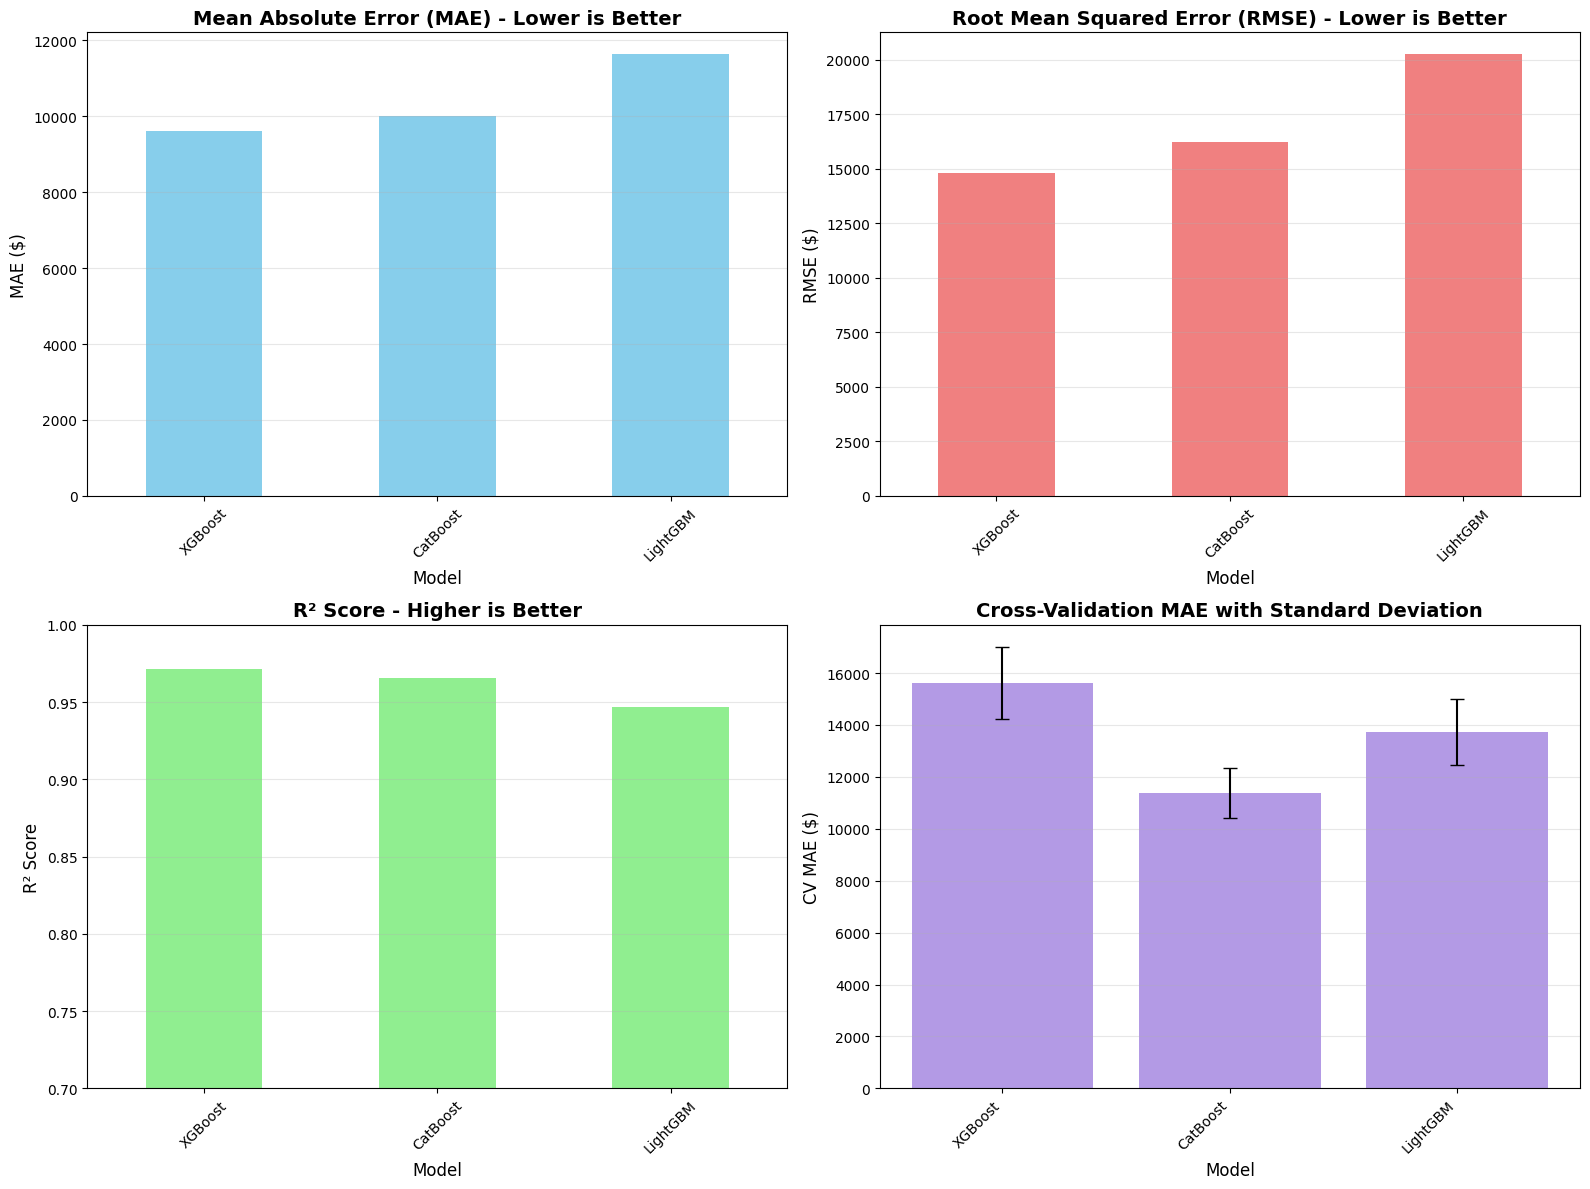

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
results_df.plot(x='Model', y='MAE', kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Mean Absolute Error (MAE) - Lower is Better', fontsize=14, fontweight='bold')
ax1.set_ylabel('MAE', fontsize=12)
ax1.set_xlabel('Model', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
results_df.plot(x='Model', y='RMSE', kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Root Mean Squared Error (RMSE) ', fontsize=14, fontweight='bold')
ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_xlabel('Model', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

ax3 = axes[1, 0]
results_df.plot(x='Model', y='R²', kind='bar', ax=ax3, color='lightgreen')
ax3.set_title('R² Score - Higher is Better', fontsize=14, fontweight='bold')
ax3.set_ylabel('R² Score', fontsize=12)
ax3.set_xlabel('Model', fontsize=12)
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0.7, 1.0])

ax4 = axes[1, 1]
x_pos = np.arange(len(results_df))
ax4.bar(x_pos, results_df['CV MAE (mean)'], yerr=results_df['CV MAE (std)'], capsize=5, color='mediumpurple', alpha=0.7)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax4.set_title('Cross-Validation MAE with Standard Deviation', fontsize=14, fontweight='bold')
ax4.set_ylabel('CV MAE ($)', fontsize=12)
ax4.set_xlabel('Model', fontsize=12)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# **COMPARAȚIE FINALĂ — TOATE MODELELE**

| #     | Model             | MAE          | RMSE         | R²         | CV MAE (mean) | CV MAE (std) |
| ----- | ----------------- | ------------ | ------------ | ---------- | ------------- | ------------ |
| 0     | **XGBoost**       | **9601.55**  | **14828.78** | **0.9713** | 15617.41      | 1389.79      |
| 1     | **CatBoost**      | 9999.26      | 16232.77     | 0.9656     | **11388.74**  | **964.87**   |
| 2     | **LightGBM**      | 11630.61     | 20253.78     | 0.9465     | 13731.99      | 1280.87      |
| 3     | Linear Regression | 21892.38     | 34297.28     | 0.8466     | —             | —            |
| 4     | Decision Tree     | 21060.28     | 32200.02     | 0.8648     | —             | —            |
| **5** | **Random Forest** | **16132.14** | **27392.48** | **0.9022** | —             | —            |



# Laborator 28 noiembrie

In [18]:
numerical_transformer_decision_tree = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7))
])

categorical_transformer_decision_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor_decision_tree = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_decision_tree, numerical_features),
        ('cat', categorical_transformer_decision_tree, categorical_features)
    ])

numerical_transformer_catboost = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7))
])

categorical_transformer_catboost = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor_catboost = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_catboost, numerical_features),
        ('cat', categorical_transformer_catboost, categorical_features)
    ]
)

X_train, X_temp, Y_train, Y_temp = train_test_split( X, Y, test_size=0.4, random_state=42 )
X_val, X_test, Y_val, Y_test = train_test_split( X_temp, Y_temp, test_size=0.5, random_state=42 )

In [19]:
models_boosting = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },

    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'regressor__max_depth': [5, 10, 15, 20, None],
            'regressor__min_samples_split': [2, 5, 10, 20],
            'regressor__min_samples_leaf': [1, 2, 4, 8],
            'regressor__max_features': ['sqrt', 'log2', None],
            'regressor__criterion': ['squared_error', 'friedman_mse']
        }
    },

    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 300, 500],
            'regressor__max_depth': [10, 15, 20, None],
            'regressor__min_samples_leaf': [1, 2, 4, 8],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__max_features': ['sqrt', 'log2', None],
            'regressor__bootstrap': [True]
        }
    },

    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 300, 500],
            'regressor__max_depth': [3, 5, 6],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__subsample': [0.7, 0.8, 1.0],
            'regressor__colsample_bytree': [0.7, 0.8, 1.0]
        }
    },

    'LightGBM': {
        'model': LGBMRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 300, 500],
            'regressor__max_depth': [-1, 5, 10],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__subsample': [0.7, 0.8],
            'regressor__colsample_bytree': [0.7, 0.8]
        }
    },
    
    'CatBoost': {
        'model': CatBoostRegressor(random_state=42, verbose=False, allow_writing_files=False),
        'params': {
            'regressor__iterations': [100, 300, 500],
            'regressor__depth': [3, 5, 7],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__subsample': [0.7, 0.8, 1.0]
        }
    }
}

In [21]:
results_boosting = {}

for model_name, configurations in models_boosting.items():
    print(f"\n{'='*80}")
    print(f"Training model: {model_name}")
    print(f"{'='*80}")
    
    if model_name == 'CatBoost':
        preprocessor_used = preprocessor_catboost
        configurations['model'].set_params(allow_writing_files=False, verbose=0)
        if categorical_features:
            cat_indices = list(range(len(numerical_features), len(numerical_features) + len(categorical_features)))
            configurations['model'].set_params(cat_features=cat_indices)
    else:
        preprocessor_used = preprocessor_decision_tree
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor_used),
        ('regressor', configurations['model'])
    ])
    
    cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    print(f"\nCross-Validation MAE: ${-cv_scores.mean():,.2f} (+/- ${cv_scores.std():,.2f})")
    
    if configurations['params']:
        print(f"\nRunning GridSearchCV cu {len(configurations['params'])} parametri...")
        grid_search = GridSearchCV( pipeline, configurations['params'], cv=5, n_jobs=-1,  scoring='neg_mean_absolute_error', verbose=1 )
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_
        print(f"\nBest parameters: {grid_search.best_params_}")
        print(f"Best CV MAE: ${-grid_search.best_score_:,.2f}")
    else:
        best_model = pipeline
        best_model.fit(X_train, Y_train)
    

    Y_train_pred = best_model.predict(X_train)
    Y_val_pred = best_model.predict(X_val)
    Y_test_pred = best_model.predict(X_test)
    
    train_mae = mean_absolute_error(Y_train, Y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
    train_r2 = r2_score(Y_train, Y_train_pred)
    
    val_mae = mean_absolute_error(Y_val, Y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(Y_val, Y_val_pred))
    val_r2 = r2_score(Y_val, Y_val_pred)
    
    test_mae = mean_absolute_error(Y_test, Y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
    test_r2 = r2_score(Y_test, Y_test_pred)
    
    print(f"\n REZULTATE - {model_name}")
    print(f"\n Train Set (60%):")
    print(f"  MAE: ${train_mae:,.2f}, RMSE: ${train_rmse:,.2f}, R²: {train_r2:.4f}")

    print(f"\n Validation Set (20%):")
    print(f"  MAE: ${val_mae:,.2f}, RMSE: ${val_rmse:,.2f}, R²: {val_r2:.4f}")

    print(f"Test Set (20%):")
    print(f"  MAE: ${test_mae:,.2f}, RMSE: ${test_rmse:,.2f}, R²: {test_r2:.4f}")
    
    r2_diff_val_test = val_r2 - test_r2
    mae_diff_val_test = abs(test_mae - val_mae)
    mae_ratio_val_test = mae_diff_val_test / val_mae if val_mae > 0 else 0
    
    print(f"\n{'─'*80}")
    print(f"ANALIZA GENERALIZĂRII (Validation → Test)")
    print(f"{'─'*80}")
    
    print(f"  Diferență R² (Val - Test): {r2_diff_val_test:+.4f}")
    print(f"  Diferență MAE (|Test - Val|): ${mae_diff_val_test:,.2f} ({mae_ratio_val_test*100:.1f}%)")
    
    # Criterii overfitting bazate pe Validation vs Test
    # Modelul are overfitting dacă performanța scade semnificativ de la Val la Test
    is_overfitting = ( abs(r2_diff_val_test) > 0.05 or mae_ratio_val_test > 0.20 )
    
    if is_overfitting:
        if r2_diff_val_test > 0:
            print(f"  Status: Performanța scade pe Test → posibil overfitting pe Validation")
        else:
            print(f"  Status: Performanța variază semnificativ → instabilitate model")
    else:
        print(f"  Status: Modelul generalizează BINE (performanță stabilă Val → Test)")
    
    r2_diff_train_val = train_r2 - val_r2
    print(f"\n  Context Train → Validation:")
    print(f"    Diferență R² (Train - Val): {r2_diff_train_val:+.4f}")
    
    results_boosting[model_name] = {
        'Train_MAE': train_mae,
        'Train_RMSE': train_rmse,
        'Train_R²': train_r2,
        'Val_MAE': val_mae,
        'Val_RMSE': val_rmse,
        'Val_R²': val_r2,
        'Test_MAE': test_mae,
        'Test_RMSE': test_rmse,
        'Test_R²': test_r2,
        'CV_MAE_mean': -cv_scores.mean(),
        'CV_MAE_std': cv_scores.std(),
        'model': best_model,
        'overfitting': is_overfitting,
        'r2_diff_val_test': r2_diff_val_test,
        'mae_diff_val_test': mae_diff_val_test,
        'r2_diff_train_val': r2_diff_train_val
    }

print("COMPARAȚIE FINALĂ - TOATE MODELELE")

results_df = pd.DataFrame({
    'Model': list(results_boosting.keys()),
    'Train MAE': [results_boosting[m]['Train_MAE'] for m in results_boosting.keys()],
    'Val MAE': [results_boosting[m]['Val_MAE'] for m in results_boosting.keys()],
    'Test MAE': [results_boosting[m]['Test_MAE'] for m in results_boosting.keys()],
    'Test R²': [results_boosting[m]['Test_R²'] for m in results_boosting.keys()],
    'Val-Test ΔR²': [results_boosting[m]['r2_diff_val_test'] for m in results_boosting.keys()],
    'Overfitting': ['Da' if results_boosting[m]['overfitting'] else 'Nu' for m in results_boosting.keys()]
})

results_df = results_df.sort_values('Test MAE')
print(results_df.to_string(index=False))

best_model_name = min(results_boosting.keys(), key=lambda k: results_boosting[k]['Test_MAE'])

print(f"\n{'='*80}")
print(f" Cel mai bun model: {best_model_name}")
print(f"{'='*80}")
print(f"\nPerformanță pe seturile de date:")
print(f"  Validation MAE: ${results_boosting[best_model_name]['Val_MAE']:,.2f}")
print(f"  Validation R²:  {results_boosting[best_model_name]['Val_R²']:.4f}")
print(f"  Test MAE:       ${results_boosting[best_model_name]['Test_MAE']:,.2f}")
print(f"  Test R²:        {results_boosting[best_model_name]['Test_R²']:.4f}")

print(f"\nAnaliza finală:")
if not results_boosting[best_model_name]['overfitting']:
    print(f"   Modelul generalizează CORECT")
    print(f"   Performanța stabilă între Validation și Test")
else:
    print(f"   Modelul prezintă semne de overfitting")
    print(f"   Performanța variază între Validation și Test")



Training model: Linear Regression

Cross-Validation MAE: $21,660.13 (+/- $3,359.18)

 REZULTATE - Linear Regression

 Train Set (60%):
  MAE: $19,944.41, RMSE: $31,409.16, R²: 0.8262

 Validation Set (20%):
  MAE: $24,751.59, RMSE: $40,243.01, R²: 0.8280
Test Set (20%):
  MAE: $20,515.03, RMSE: $27,558.05, R²: 0.8447

────────────────────────────────────────────────────────────────────────────────
ANALIZA GENERALIZĂRII (Validation → Test)
────────────────────────────────────────────────────────────────────────────────
  Diferență R² (Val - Test): -0.0167
  Diferență MAE (|Test - Val|): $4,236.55 (17.1%)
  Status: Modelul generalizează BINE (performanță stabilă Val → Test)

  Context Train → Validation:
    Diferență R² (Train - Val): -0.0018

Training model: Decision Tree

Cross-Validation MAE: $27,841.10 (+/- $3,876.21)

Running GridSearchCV cu 5 parametri...
Fitting 5 folds for each of 480 candidates, totalling 2400 fits

Best parameters: {'regressor__criterion': 'squared_error', 'r

c:\Users\dariu\Documents\GithubRepos\house-price-prediction-integra\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\dariu\Documents\GithubRepos\house-price-prediction-integra\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\dariu\Documents\GithubRepos\house-price-prediction-integra\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Cross-Validation MAE: $12,489.56 (+/- $1,851.21)

Running GridSearchCV cu 4 parametri...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters: {'regressor__depth': 5, 'regressor__iterations': 500, 'regressor__learning_rate': 0.1, 'regressor__subsample': 1.0}
Best CV MAE: $12,281.99

 REZULTATE - CatBoost

 Train Set (60%):
  MAE: $2,547.41, RMSE: $3,226.90, R²: 0.9982

 Validation Set (20%):
  MAE: $12,641.84, RMSE: $24,017.45, R²: 0.9387
Test Set (20%):
  MAE: $9,228.14, RMSE: $13,909.50, R²: 0.9604

────────────────────────────────────────────────────────────────────────────────
ANALIZA GENERALIZĂRII (Validation → Test)
────────────────────────────────────────────────────────────────────────────────
  Diferență R² (Val - Test): -0.0217
  Diferență MAE (|Test - Val|): $3,413.69 (27.0%)
  Status: Performanța variază semnificativ → instabilitate model

  Context Train → Validation:
    Diferență R² (Train - Val): +0.0594
COMPARAȚIE FINALĂ - TOATE MODELELE
    

### **Tabel general al stabilității**

| Model                 | Train MAE | Val MAE | Test MAE | Train R² | Val R² | Test R² | ΔR² Val→Test | ΔMAE Val→Test |
| --------------------- | --------- | ------- | -------- | -------- | ------ | ------- | ------------ | ------------- | 
| **Linear Regression** | 19,944    | 24,751  | 20,515   | 0.8262   | 0.8280 | 0.8447  | **-0.0167**  | 17.1%         | 
| **Decision Tree**     | 16,366    | 26,176  | 22,089   | 0.8837   | 0.8181 | 0.8103  | **+0.0078**  | 15.6%         |  
| **Random Forest**     | 7,578     | 17,944  | 14,240   | 0.9639   | 0.8897 | 0.9197  | **-0.0300**  | 20.6%         | 
| **XGBoost**           | 2,246     | 11,903  | 9,660    | 0.9986   | 0.9512 | 0.9562  | **-0.0050**  | 18.8%         | 
| **LightGBM**          | 1,880     | 13,685  | 10,261   | 0.9989   | 0.9189 | 0.9553  | **-0.0364**  | 25.0%         | 
| **CatBoost**          | 2,547     | 12,641  | 9,228    | 0.9982   | 0.9387 | 0.9604  | **-0.0217**  | 27.0%         | 




# Stacking assignment - 2 decembrie

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd


In [ ]:
df = pd.read_csv('house_prices_selection.csv')
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
boolean_features = df.select_dtypes(include=['bool']).columns.tolist()

print(f"Coloane numerice ({len(numerical_features)}): {numerical_features}")
print(f"\nColoane categorice ({len(categorical_features)}): {categorical_features}")
print(f"\nColoane booleene ({len(boolean_features)}): {boolean_features}")

Coloane numerice (19): ['EVI', 'ZoningScore', 'Price_per_m^2', 'PDI', 'SalePrice', 'LotFrontage', 'LotArea', 'WoodDeckSF', 'OpenPorchSF', 'FullBath', 'GarageCars', 'GarageArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF']

Coloane categorice (5): ['KitchenQual', 'PavedDrive', 'BsmtQual', 'CentralAir', 'Foundation']

Coloane booleene (8): ['MSZoning_RL', 'LotConfig_CulDSac', 'LandContour_HLS', 'LotShape_IR2', 'Condition1_Norm', 'Condition1_Feedr', 'LotShape_Reg', 'MSZoning_RM']


In [ ]:
numerical_features.remove('SalePrice')
print(f"Coloane numerice ({len(numerical_features)}): {numerical_features}")
print(f"\nColoane categorice ({len(categorical_features)}): {categorical_features}")

for cols in boolean_features:
    df[cols] = df[cols].astype(int)

numerical_features.extend(boolean_features)
print(f"\nColoane numerice (inclusiv boolean) ({len(numerical_features)}): {numerical_features}")
print(f"\nColoane categorice ({len(categorical_features)}): {categorical_features}")

Coloane numerice (18): ['EVI', 'ZoningScore', 'Price_per_m^2', 'PDI', 'LotFrontage', 'LotArea', 'WoodDeckSF', 'OpenPorchSF', 'FullBath', 'GarageCars', 'GarageArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF']

Coloane categorice (5): ['KitchenQual', 'PavedDrive', 'BsmtQual', 'CentralAir', 'Foundation']

Coloane numerice (inclusiv boolean) (26): ['EVI', 'ZoningScore', 'Price_per_m^2', 'PDI', 'LotFrontage', 'LotArea', 'WoodDeckSF', 'OpenPorchSF', 'FullBath', 'GarageCars', 'GarageArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'MSZoning_RL', 'LotConfig_CulDSac', 'LandContour_HLS', 'LotShape_IR2', 'Condition1_Norm', 'Condition1_Feedr', 'LotShape_Reg', 'MSZoning_RM']

Coloane categorice (5): ['KitchenQual', 'PavedDrive', 'BsmtQual', 'CentralAir', 'Foundation']


In [ ]:
X = df.drop('SalePrice', axis=1)
Y = df['SalePrice']
print(f"Features shape: {X.shape}")
print(f"Target shape: {Y.shape}")

Features shape: (1460, 31)
Target shape: (1460,)


In [ ]:
df_clean = df.dropna()
X_clean = df_clean.drop('SalePrice', axis=1)
Y_clean = df_clean['SalePrice']
print(f"\nDataset după eliminarea valorilor lipsă: {df_clean.shape}")
print(f"Rânduri eliminate: {len(df) - len(df_clean)}")


Dataset după eliminarea valorilor lipsă: (1164, 32)
Rânduri eliminate: 296


In [ ]:
numeric_features_clean = X_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_clean = X_clean.select_dtypes(include=['object']).columns.tolist()

In [ ]:
preprocessor_data = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_clean),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features_clean)
    ])

X_train, X_test, Y_train, Y_test = train_test_split( X_clean, Y_clean, test_size=0.2, random_state=42)

In [ ]:
base_estimators_1 = [
    ('ridge', Ridge(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42)),
    ('svm', SVR()),
    ('xgb', XGBRegressor(random_state=42))
]

base_estimators_2 = [
    ('xgb', XGBRegressor(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42)),
    ('knn', KNeighborsRegressor()),
    ('lasso', Lasso(random_state=42))
]

base_estimators_3 = [
    ('catboost', CatBoostRegressor(random_state=42, verbose=False, allow_writing_files=False)),
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('lgbm', LGBMRegressor(random_state=42, verbose=-1))
]

In [ ]:
param_grids = {
    'Stacking 1': {
        'stacking__ridge__alpha': [1.0, 10.0],
        'stacking__rf__n_estimators': [100],
        'stacking__rf__max_depth': [10, None],
        'stacking__svm__C': [1, 10],
        'stacking__svm__kernel': ['rbf'],
        'stacking__final_estimator__C': [1, 10],
        'stacking__final_estimator__kernel': ['rbf'],
        'stacking__xgb__n_estimators': [100],
        'stacking__xgb__learning_rate': [0.05, 0.1],
        'stacking__xgb__max_depth': [3, 5]
    },
    'Stacking 2': {
        'stacking__xgb__n_estimators': [100],
        'stacking__xgb__learning_rate': [0.05, 0.1],
        'stacking__xgb__max_depth': [3, 5],
        'stacking__gbr__n_estimators': [100],
        'stacking__gbr__learning_rate': [0.1],
        'stacking__knn__n_neighbors': [5, 7],
        'stacking__lasso__alpha': [1.0],
        'stacking__final_estimator__fit_intercept': [True]
    },
    'Stacking 3': {
        'stacking__catboost__iterations': [100],
        'stacking__catboost__learning_rate': [0.05, 0.1],
        'stacking__dt__max_depth': [10, None],
        'stacking__dt__min_samples_split': [2],
        'stacking__lgbm__n_estimators': [100],
        'stacking__lgbm__learning_rate': [0.1],
        'stacking__final_estimator__n_estimators': [100],
        'stacking__final_estimator__max_depth': [10, 20]
    }
}

In [ ]:
stacking_pipelines = {
    'Stacking 1': Pipeline([
        ('preprocessor', preprocessor_data),
        ('stacking', StackingRegressor(
            estimators=base_estimators_1,
            final_estimator=SVR(),
            cv=5,
            n_jobs=-1
        ))
    ]),

    'Stacking 2': Pipeline([
        ('preprocessor', preprocessor_data),
        ('stacking', StackingRegressor(
            estimators=base_estimators_2,
            final_estimator=LinearRegression(),
            cv=5,
            n_jobs=-1
        ))
    ]),

    'Stacking 3': Pipeline([
        ('preprocessor', preprocessor_data),
        ('stacking', StackingRegressor(
            estimators=base_estimators_3,
            final_estimator=RandomForestRegressor(random_state=42),
            cv=5,
            n_jobs=-1
        ))
    ])
}

In [ ]:
results = {}

for model_name, pipeline in stacking_pipelines.items():
    print(f"\n{'='*60}")
    print(f"Tuning {model_name}")
    print(f"{'='*60}")

    from sklearn.model_selection import ParameterGrid
    n_combinations = len(list(ParameterGrid(param_grids[model_name])))
    print(f"Număr combinații: {n_combinations}")
    print(f"Total fits (cu CV=5): {n_combinations * 5}")

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model_name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=2
    )

    grid.fit(X_train, Y_train)

    print(f"\nBest params: {grid.best_params_}")
    print(f"Best CV score (neg_MSE): {grid.best_score_:.4f}")
    print(f"Best CV RMSE: {np.sqrt(-grid.best_score_):.4f}")

    best_model = grid.best_estimator_
    Y_pred = best_model.predict(X_test)

    test_mse = mean_absolute_error(Y_test, Y_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(Y_test, Y_pred)

    print(f"\nTest MSE: {test_mse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    results[model_name] = {
        'best_params': grid.best_params_,
        'best_cv_score': grid.best_score_,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'best_model': best_model
    }

print(f"\n{'='*60}")
print("COMPARAȚIE FINALĂ")
print(f"{'='*60}")
for model_name, res in results.items():
    print(f"{model_name}: Test RMSE={res['test_rmse']:.2f}, R²={res['test_r2']:.4f}")


Tuning Stacking 1
Număr combinații: 16
Total fits (cu CV=5): 80
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best params: {'stacking__final_estimator__C': 10, 'stacking__final_estimator__kernel': 'rbf', 'stacking__rf__max_depth': 10, 'stacking__rf__n_estimators': 100, 'stacking__ridge__alpha': 10.0, 'stacking__svm__C': 1, 'stacking__svm__kernel': 'rbf'}
Best CV score (neg_MSE): -7055706761.7475
Best CV RMSE: 83998.2545

Test MSE: 56284.2326
Test RMSE: 237.2430
Test R²: -0.0463

Tuning Stacking 2
Număr combinații: 8
Total fits (cu CV=5): 40
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params: {'stacking__final_estimator__fit_intercept': True, 'stacking__gbr__learning_rate': 0.1, 'stacking__gbr__n_estimators': 100, 'stacking__knn__n_neighbors': 5, 'stacking__lasso__alpha': 1.0, 'stacking__xgb__learning_rate': 0.05, 'stacking__xgb__max_depth': 3, 'stacking__xgb__n_estimators': 100}
Best CV score (neg_MSE): -770709740.3604
Best CV RMSE: 27761.6595

Te

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best params: {'stacking__catboost__iterations': 100, 'stacking__catboost__learning_rate': 0.05, 'stacking__dt__max_depth': None, 'stacking__dt__min_samples_split': 2, 'stacking__final_estimator__max_depth': 20, 'stacking__final_estimator__n_estimators': 100, 'stacking__lgbm__learning_rate': 0.1, 'stacking__lgbm__n_estimators': 100}
Best CV score (neg_MSE): -1022683761.4251
Best CV RMSE: 31979.4272

Test MSE: 15254.0674
Test RMSE: 123.5074
Test R²: 0.9180

COMPARAȚIE FINALĂ
Stacking 1: Test RMSE=237.24, R²=-0.0463
Stacking 2: Test RMSE=118.86, R²=0.9340
Stacking 3: Test RMSE=123.51, R²=0.9180


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
print(f"\n{'='*60}")
print("COMPARAȚIE FINALĂ")
print(f"{'='*60}")
print(f"{'Model':<20} {'Test MSE':<15} {'Test RMSE':<15} {'Test R²':<10}")
print(f"{'-'*60}")
for model_name, res in results.items():
    print(f"{model_name:<20} {res['test_mse']:<15.4f} {res['test_rmse']:<15.4f} {res['test_r2']:<10.4f}")


COMPARAȚIE FINALĂ
Model                Test MSE        Test RMSE       Test R²   
------------------------------------------------------------
Stacking 1           56284.2326      237.2430        -0.0463   
Stacking 2           14128.2294      118.8622        0.9340    
Stacking 3           15254.0674      123.5074        0.9180    


# Laboratory 5 December on Classification methods ( SHAP & Permutation Importance )

In [35]:
import shap
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [30]:
xgb_pipeline = results_boosting['XGBoost']['model']
preprocessor = xgb_pipeline.named_steps['preprocessor']
xgb_model = xgb_pipeline.named_steps['regressor']

X_test_preprocessed = preprocessor.transform(X_test)

numeric_feature_names = list(numerical_features)
onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = list(onehot_encoder.get_feature_names_out(categorical_features))

feature_names = numeric_feature_names + categorical_feature_names
print(f"Total features after preprocessing: {len(feature_names)}")

X_test_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)


Total features after preprocessing: 40



PERMUTATION IMPORTANCE pentru XGBoost...


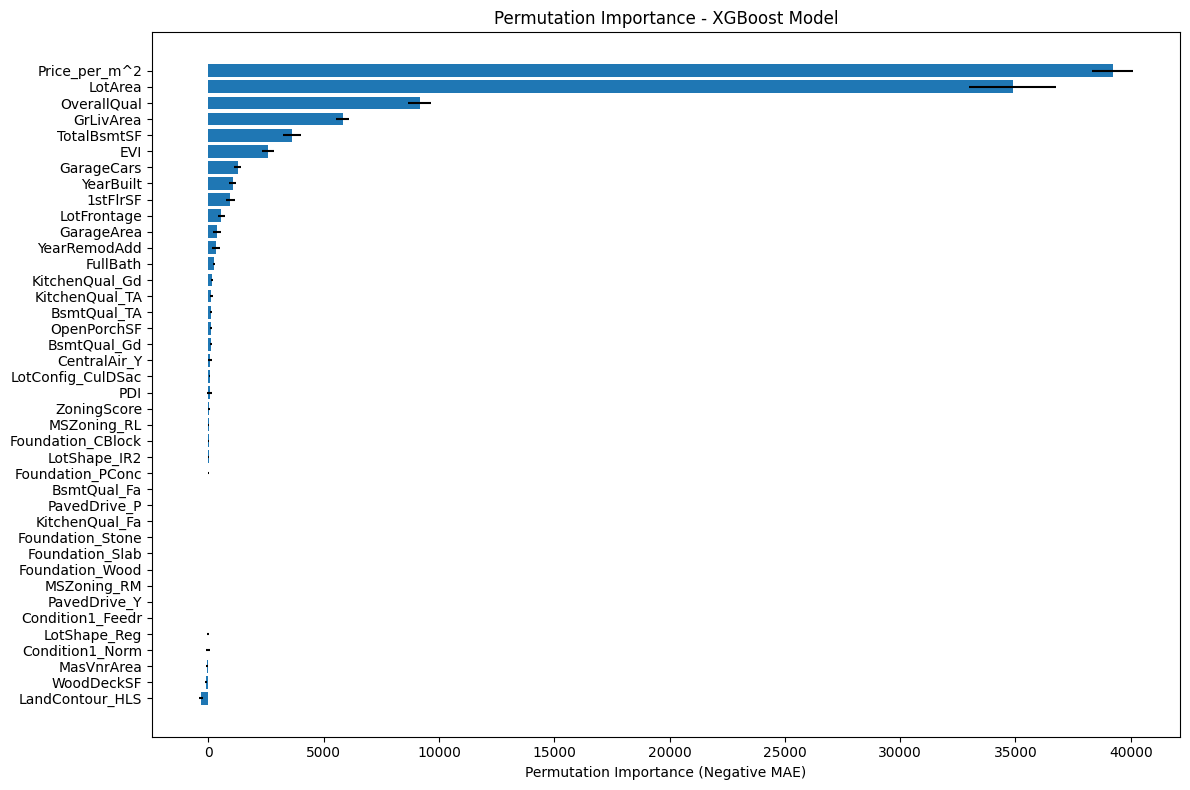

In [40]:
print("\n" + "="*70)
print("PERMUTATION IMPORTANCE pentru XGBoost...")
print("="*70)

perm_result = permutation_importance( xgb_model, X_test_preprocessed, Y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring= 'neg_mean_absolute_error' )
permutation_importance_values = perm_result.importances_mean
permutation_std = perm_result.importances_std
sorted_permutation_index = permutation_importance_values.argsort() 

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(sorted_permutation_index)), permutation_importance_values[sorted_permutation_index], xerr=permutation_std[sorted_permutation_index])
ax.set_yticks(range(len(sorted_permutation_index)))
ax.set_yticklabels(np.array(feature_names)[sorted_permutation_index])
ax.set_xlabel("Permutation Importance (Negative MAE)")
ax.set_title("Permutation Importance - XGBoost Model")
plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*80)
print("SHAP ANALYSIS (TreeExplainer)")
print("="*80)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_preprocessed)
print(f"SHAP values shape: {shap_values.shape}")
print(f"Expected shape: ({len(X_test_preprocessed)}, {len(feature_names)})")

SHAP values shape: (292, 40)
Expected shape: (292, 40)


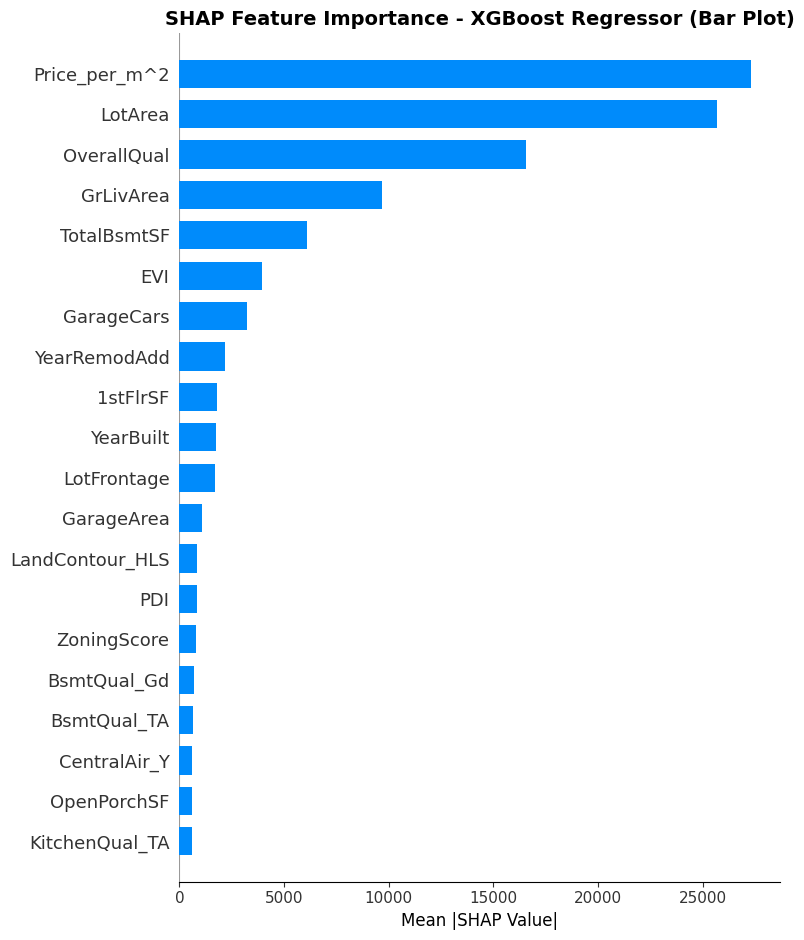

In [44]:
# 4.1 Bar Plot - Feature Importance
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_df, plot_type="bar", max_display=20, show=False)
plt.title('SHAP Feature Importance - XGBoost Regressor (Bar Plot)', fontsize=14, fontweight='bold')
plt.xlabel('Mean |SHAP Value|', fontsize=12)
plt.tight_layout()
plt.show()

In [50]:
shap_importance_df = pd.DataFrame({'Feature': feature_names, 'SHAP_Importance': np.abs(shap_values).mean(axis=0)
    }).sort_values('SHAP_Importance', ascending=False).head(40).reset_index(drop=True)

shap_importance_df.index += 1
shap_importance_df.index.name = 'Rank'

print("\nTop 40 Features (SHAP Importance):")
print(shap_importance_df)


Top 40 Features (SHAP Importance):
                Feature  SHAP_Importance
Rank                                    
1         Price_per_m^2     27329.695312
2               LotArea     25692.556641
3           OverallQual     16578.943359
4             GrLivArea      9659.401367
5           TotalBsmtSF      6075.427734
6                   EVI      3939.573730
7            GarageCars      3244.698975
8          YearRemodAdd      2173.207275
9              1stFlrSF      1789.892090
10            YearBuilt      1772.690552
11          LotFrontage      1682.457886
12           GarageArea      1060.870483
13      LandContour_HLS       853.649414
14                  PDI       829.759155
15          ZoningScore       809.206299
16          BsmtQual_Gd       695.645630
17          BsmtQual_TA       637.427063
18         CentralAir_Y       612.938599
19          OpenPorchSF       598.394958
20       KitchenQual_TA       591.338318
21             FullBath       576.660583
22           WoodDeck


Top 30 Features - Comparație:
          Feature         SHAP  Permutation  SHAP_norm  Permutation_norm
    Price_per_m^2 27329.695312 39209.235547   1.000000          1.000000
          LotArea 25692.556641 34879.993359   0.940097          0.889586
      OverallQual 16578.943359  9161.172461   0.606627          0.233648
        GrLivArea  9659.401367  5820.722266   0.353440          0.148453
      TotalBsmtSF  6075.427734  3634.496094   0.222301          0.092695
              EVI  3939.573730  2583.675879   0.144150          0.065895
       GarageCars  3244.698975  1275.431250   0.118724          0.032529
     YearRemodAdd  2173.207275   315.458984   0.079518          0.008046
         1stFlrSF  1789.892090   948.783887   0.065493          0.024198
        YearBuilt  1772.690552  1056.275586   0.064863          0.026939
      LotFrontage  1682.457886   559.367480   0.061562          0.014266
       GarageArea  1060.870483   373.929980   0.038818          0.009537
  LandContour_HLS   

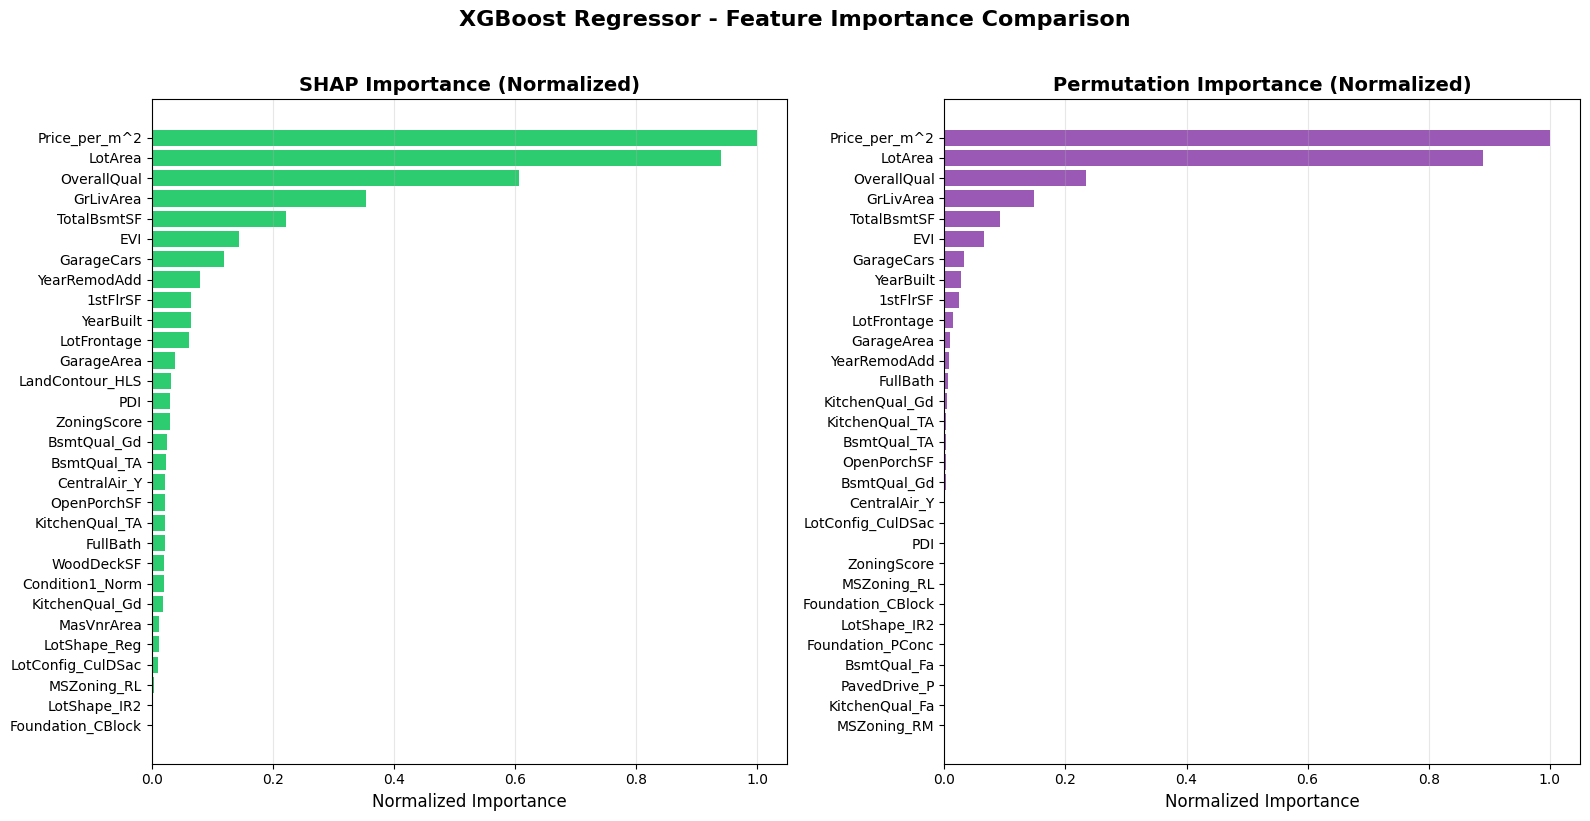

In [51]:
comparison_df = pd.DataFrame({ 'Feature': feature_names, 'SHAP': shap_importance, 'Permutation': permutation_importance_values })

comparison_df['SHAP_norm'] = comparison_df['SHAP'] / comparison_df['SHAP'].max()
comparison_df['Permutation_norm'] = comparison_df['Permutation'] / comparison_df['Permutation'].max()
comparison_df = comparison_df.sort_values('SHAP', ascending=False)

print("\nTop 30 Features - Comparație:")
print(comparison_df.head(30).to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top_shap = comparison_df.nlargest(30, 'SHAP')
axes[0].barh(range(30), top_shap['SHAP_norm'].values[::-1], color='#2ecc71')
axes[0].set_yticks(range(30))
axes[0].set_yticklabels(top_shap['Feature'].values[::-1], fontsize=10)
axes[0].set_title('SHAP Importance (Normalized)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Normalized Importance', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

top_perm = comparison_df.nlargest(30, 'Permutation')
axes[1].barh(range(30), top_perm['Permutation_norm'].values[::-1], color='#9b59b6')
axes[1].set_yticks(range(30))
axes[1].set_yticklabels(top_perm['Feature'].values[::-1], fontsize=10)
axes[1].set_title('Permutation Importance (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Normalized Importance', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.suptitle('XGBoost Regressor - Feature Importance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [61]:
print("\n" + "="*80)
print("TOP 10 FEATURES - comparație SHAP vs Permutation")
print("="*80)

top_shap = set(comparison_df.nlargest(10, 'SHAP')['Feature'])
top_perm = set(comparison_df.nlargest(10, 'Permutation')['Feature'])

common = top_shap & top_perm
shap_only = top_shap - top_perm
perm_only = top_perm - top_shap

print(f"\n Both methods ({len(common)}/10):")
for feat in sorted(common):
    row = comparison_df[comparison_df['Feature'] == feat].iloc[0]
    print(f"  • {feat:<40} SHAP: {row['SHAP']:>8.2f}  Perm: {row['Permutation']:>10.6f}")

print(f"\n SHAP only ({len(shap_only)}/10):")
for feat in sorted(shap_only):
    row = comparison_df[comparison_df['Feature'] == feat].iloc[0]
    print(f"  • {feat} {row['SHAP']:>8.2f}")

print(f"\n Permutation only ({len(perm_only)}/10):")
for feat in sorted(perm_only):
    row = comparison_df[comparison_df['Feature'] == feat].iloc[0]
    print(f"  • {feat} {row['Permutation']:>10.6f}")


TOP 10 FEATURES - comparație SHAP vs Permutation

 Both methods (9/10):
  • 1stFlrSF                                 SHAP:  1789.89  Perm: 948.783887
  • EVI                                      SHAP:  3939.57  Perm: 2583.675879
  • GarageCars                               SHAP:  3244.70  Perm: 1275.431250
  • GrLivArea                                SHAP:  9659.40  Perm: 5820.722266
  • LotArea                                  SHAP: 25692.56  Perm: 34879.993359
  • OverallQual                              SHAP: 16578.94  Perm: 9161.172461
  • Price_per_m^2                            SHAP: 27329.70  Perm: 39209.235547
  • TotalBsmtSF                              SHAP:  6075.43  Perm: 3634.496094
  • YearBuilt                                SHAP:  1772.69  Perm: 1056.275586

 SHAP only (1/10):
  • YearRemodAdd  2173.21

 Permutation only (1/10):
  • LotFrontage 559.367480
